In [1]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb

from scipy.stats import randint, uniform

from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

import shap


c:\Users\aliss_u3voar7\anaconda3\envs\career_lab\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Extração dos Dados

In [2]:
dataset = joblib.load('../data/processed/dataset_treated.joblib')
dataset.head()

,gender,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure_cat,MonthlyCharges_cat,TotalCharges_cat,Churn_label
0,Female,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,"(-1.0, 6.0]","(25.0, 59.0]","(18.0, 267.0]",0
1,Male,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,"(20.0, 40.0]","(25.0, 59.0]","(944.0, 2049.0]",0
2,Male,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,"(-1.0, 6.0]","(25.0, 59.0]","(18.0, 267.0]",1
3,Male,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,"(40.0, 60.0]","(25.0, 59.0]","(944.0, 2049.0]",0
4,Female,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,"(-1.0, 6.0]","(59.0, 79.0]","(18.0, 267.0]",1


In [3]:
df=dataset.copy()

df.drop(columns=['Churn'], inplace=True)
df.rename(columns={'Churn_label':'Churn'}, inplace=True)

target = ['Churn']
for col in df.columns.difference(target):
    df[col] = df[col].astype(str).astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   gender              7043 non-null   category
 1   Dependents          7043 non-null   category
 2   PhoneService        7043 non-null   category
 3   MultipleLines       7043 non-null   category
 4   InternetService     7043 non-null   category
 5   OnlineSecurity      7043 non-null   category
 6   OnlineBackup        7043 non-null   category
 7   DeviceProtection    7043 non-null   category
 8   TechSupport         7043 non-null   category
 9   StreamingTV         7043 non-null   category
 10  StreamingMovies     7043 non-null   category
 11  Contract            7043 non-null   category
 12  PaperlessBilling    7043 non-null   category
 13  PaymentMethod       7043 non-null   category
 14  tenure_cat          7043 non-null   category
 15  MonthlyCharges_cat  7043 non-null   ca

# Tratamento dos Dados

In [4]:

X_train, X_test_, y_train, y_test_ = train_test_split(df.drop('Churn', axis=1), df['Churn'], test_size=0.3,  random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train,y_train)

X_cal, X_test, y_cal, y_test = train_test_split(X_test_, y_test_, test_size=0.15,  random_state=42)


print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_train_resampled: {X_train_resampled.shape}, X_test_: {X_test_.shape}, y_train_resampled: {y_train_resampled.shape}, y_test_: {y_test_.shape}')
print(f'X_cal: {X_cal.shape}, X_test: {X_test.shape}, y_cal: {y_cal.shape}, y_test: {y_test.shape}')

joblib.dump(X_train, '../data/processed/X_train.joblib')
joblib.dump(y_train, '../data/processed/y_train.joblib')

joblib.dump(X_train_resampled, '../data/processed/X_train_resampled.joblib')
joblib.dump(y_train_resampled, '../data/processed/y_train_resampled.joblib')

joblib.dump(X_test_, '../data/processed/X_test_.joblib')
joblib.dump(y_test_, '../data/processed/y_test_.joblib')

joblib.dump(X_cal, '../data/processed/X_cal.joblib')
joblib.dump(X_test, '../data/processed/X_test.joblib')

joblib.dump(y_cal, '../data/processed/y_cal.joblib')
joblib.dump(y_test, '../data/processed/y_test.joblib')

X_train: (4930, 17), y_train: (4930,)
X_train_resampled: (2590, 17), X_test_: (2113, 17), y_train_resampled: (2590,), y_test_: (2113,)
X_cal: (1796, 17), X_test: (317, 17), y_cal: (1796,), y_test: (317,)


['../data/processed/y_test.joblib']

Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


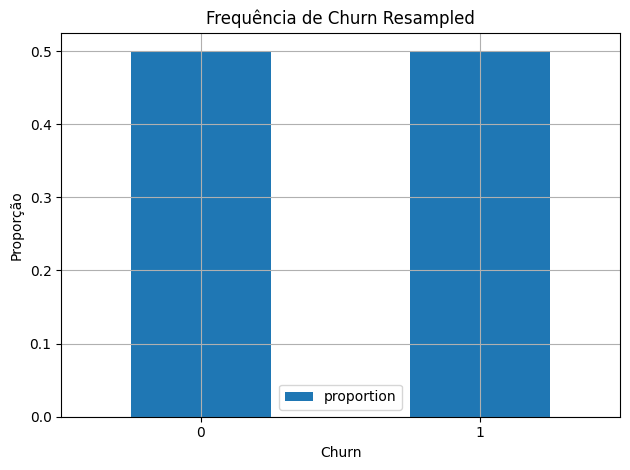

In [5]:
churn_freq = y_train_resampled.value_counts(normalize=True)
print(churn_freq)

churn_freq.plot.bar(x='Churn', y='proportion', legend=True,  title='Frequência de Churn Resampled', 
                ylabel='Proporção', xlabel='Churn',rot=0, style='seaborn-v0_8', grid=True)
plt.tight_layout()
plt.savefig('../reports/figures/descr_churn_freq_resampled.png')
plt.show()

# Modelagem

In [6]:
# Cria datasets - LightGBM detecta automaticamente as categorias
train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)
test_data_ = lgb.Dataset(X_test_, label=y_test_, reference=train_data)

cal_data = lgb.Dataset(X_cal, label=y_cal, reference=train_data)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

joblib.dump(train_data, '../data/processed/train_data_lgb.joblib')
joblib.dump(test_data_, '../data/processed/test_data_lgb_test_.joblib')
joblib.dump(cal_data, '../data/processed/cal_data_lgb.joblib')
joblib.dump(test_data, '../data/processed/test_data_lgb.joblib')

['../data/processed/test_data_lgb.joblib']

In [7]:
param_dist = {
    # Controle de complexidade da árvore
    'num_leaves': randint(20, 100),
    'max_depth': randint(3, 12),
    
    # Taxa de aprendizado e iterações
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 1000),
    
    # Regularização para evitar overfitting
    'min_child_samples': randint(10, 100),
    'min_child_weight': uniform(0.001, 0.1),
    'min_split_gain': uniform(0.0, 0.1),
    
    # Amostragem e regularização
    'feature_fraction': uniform(0.6, 0.4),  # 0.6-1.0
    'bagging_fraction': uniform(0.6, 0.4),  # 0.6-1.0
    'bagging_freq': randint(1, 10),
    
    # Regularização L1/L2
    'lambda_l1': uniform(0.0, 1.0),
    'lambda_l2': uniform(0.0, 1.0),
    
    # Métodos de boosting
    'boosting_type': ['gbdt', 'dart', 'goss'],
    
    # Calibração de probabilidades
    'sigmoid': uniform(0.5, 2.0),  # 0.5-2.5
}

In [8]:
# Usa a interface scikit-learn do LightGBM
lgb_model = lgb.LGBMClassifier(objective='binary', verbosity=-1)

random_search = RandomizedSearchCV(
    lgb_model,
    param_dist,
    n_iter=50,           # Número de combinações testadas
    cv=5,                # 5-fold CV
    scoring='neg_log_loss',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Ajusta apenas nos dados de treino
random_search.fit(X_train_resampled, y_train_resampled)

print("Melhores parâmetros:", random_search.best_params_)
print("Melhor score:", random_search.best_score_)

# Usa os melhores hiperparâmetros no modelo final
best_params = random_search.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\aliss_u3voar7\anaconda3\envs\career_lab\lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
55 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\aliss_u3voar7\anaconda3\envs\career_lab\lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\aliss_u3voar7\anaconda3\envs\career_lab\lib\site-packages\lightgbm\sklearn.py", line 1560, in fit
    super().fit(
  File "c:\Users\aliss_u3voar7\anaconda3\envs\career_lab\lib\site-packages\lightgbm\sklearn.py", line 1049, in fit
    self._Boos

Melhores parâmetros: {'bagging_fraction': np.float64(0.7801997007878172), 'bagging_freq': 2, 'boosting_type': 'gbdt', 'feature_fraction': np.float64(0.9862528132298237), 'lambda_l1': np.float64(0.8083973481164611), 'lambda_l2': np.float64(0.3046137691733707), 'learning_rate': np.float64(0.03930163420191516), 'max_depth': 6, 'min_child_samples': 69, 'min_child_weight': np.float64(0.013203823484477885), 'min_split_gain': np.float64(0.04951769101112702), 'n_estimators': 134, 'num_leaves': 97, 'sigmoid': np.float64(1.2821212151464816)}
Melhor score: -0.4913304339312129


In [9]:
best_model = lgb.LGBMClassifier(**best_params, verbosity=-1)
best_model.fit(
    X_train_resampled, y_train_resampled,
    eval_set=[(X_cal, y_cal)],     
)

joblib.dump(best_model, '../models/best_model_lgb.joblib')

['../models/best_model_lgb.joblib']

In [10]:
# Faze previsões nos conjuntos de calibração e teste
y_cal_proba = best_model.predict_proba(X_cal)

# Converte probabilidades em classes (threshold 0.5)
y_cal_pred = best_model.predict(X_cal)

joblib.dump(y_cal_proba, '../data/processed/y_cal_proba.joblib')
joblib.dump(y_cal_pred, '../data/processed/y_cal_pred.joblib')

['../data/processed/y_cal_pred.joblib']

# Análise dos Resultados

=== AUC Score ===
Calibração: 0.7687

=== Classification Report (Calibração) ===
              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1299
           1       0.52      0.83      0.64       497

    accuracy                           0.74      1796
   macro avg       0.72      0.77      0.72      1796
weighted avg       0.81      0.74      0.75      1796



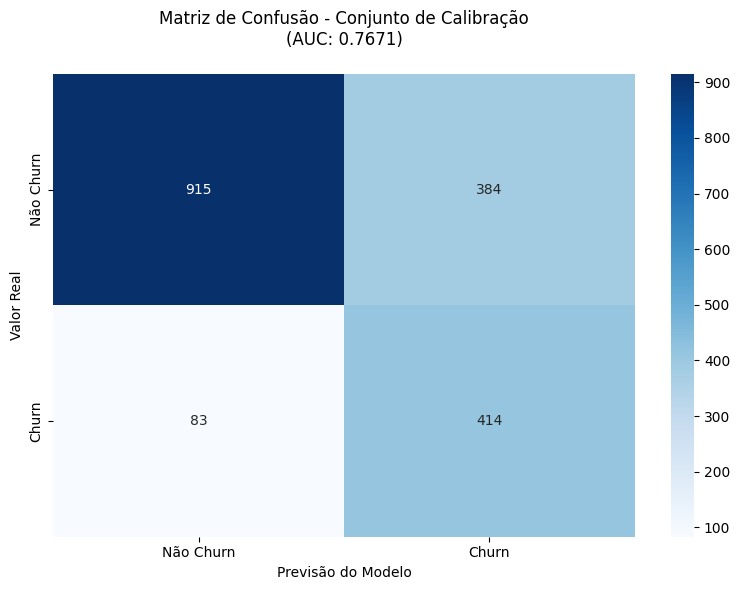

In [11]:
print("=== AUC Score ===")
print(f"Calibração: {roc_auc_score(y_cal, y_cal_pred):.4f}")

print("\n=== Classification Report (Calibração) ===")
print(classification_report(y_cal, y_cal_pred))

# Calcula matriz de confusão
cm = confusion_matrix(y_cal, y_cal_pred)

# Plota matriz de confusão com labels e porcentagens
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Não Churn', 'Churn'],
            yticklabels=['Não Churn', 'Churn'])
plt.title('Matriz de Confusão - Conjunto de Calibração\n(AUC: 0.7671)\n')
plt.ylabel('Valor Real')
plt.xlabel('Previsão do Modelo')
plt.tight_layout()
plt.show()

In [12]:
dataset_raw = joblib.load('../data/raw/data_raw.joblib')
dataset = dataset_raw.copy()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


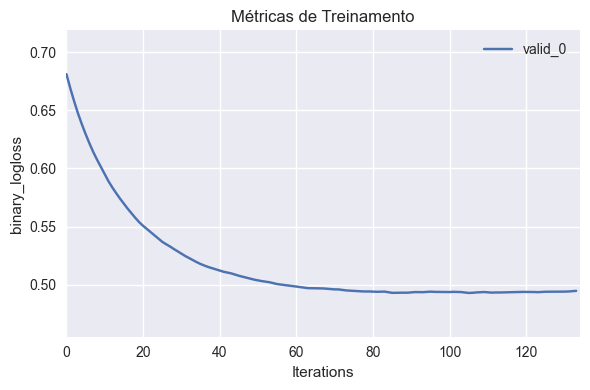

In [13]:
plt.style.use('seaborn-v0_8')
# Plot de importância simplificado
# lgb.plot_importance(best_model, title='Importância das Features',figsize=(10, 6))
# plt.tight_layout()
# plt.show()

# Plot de métricas simplificado
lgb.plot_metric(best_model, figsize=(6, 4) ,title='Métricas de Treinamento')
plt.tight_layout()
plt.show()

# Plot da árvore (se Graphviz instalado)
# try:
#     lgb.plot_tree(best_model, tree_index=0,orientation='vertical',figsize=(50, 30))
#     plt.tight_layout()
#     plt.show()
# except:
#     print("Instale graphviz para visualizar árvores")

c:\Users\aliss_u3voar7\anaconda3\envs\career_lab\lib\site-packages\shap\explainers\_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


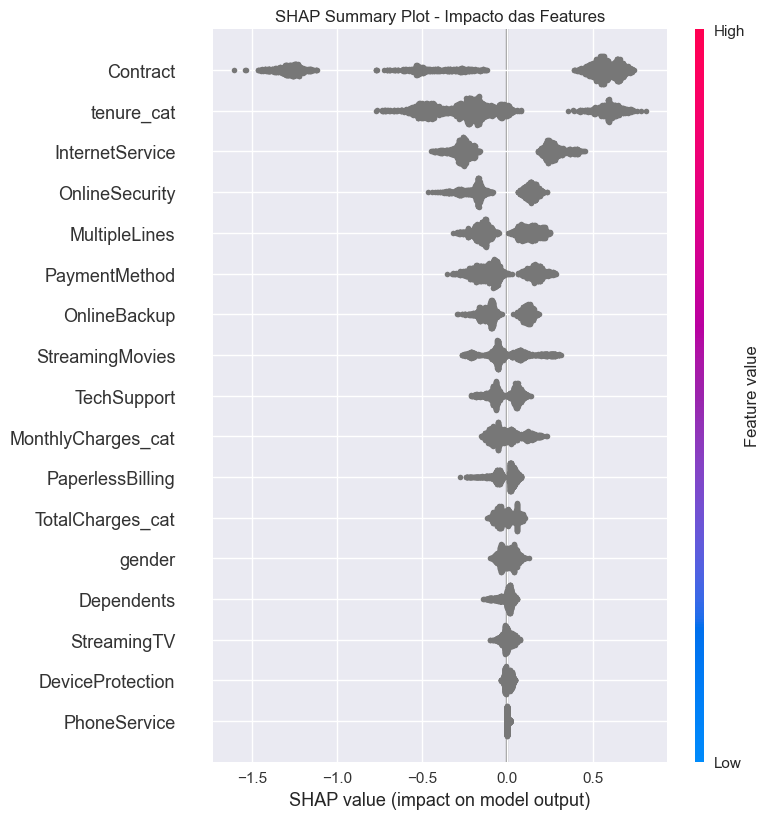

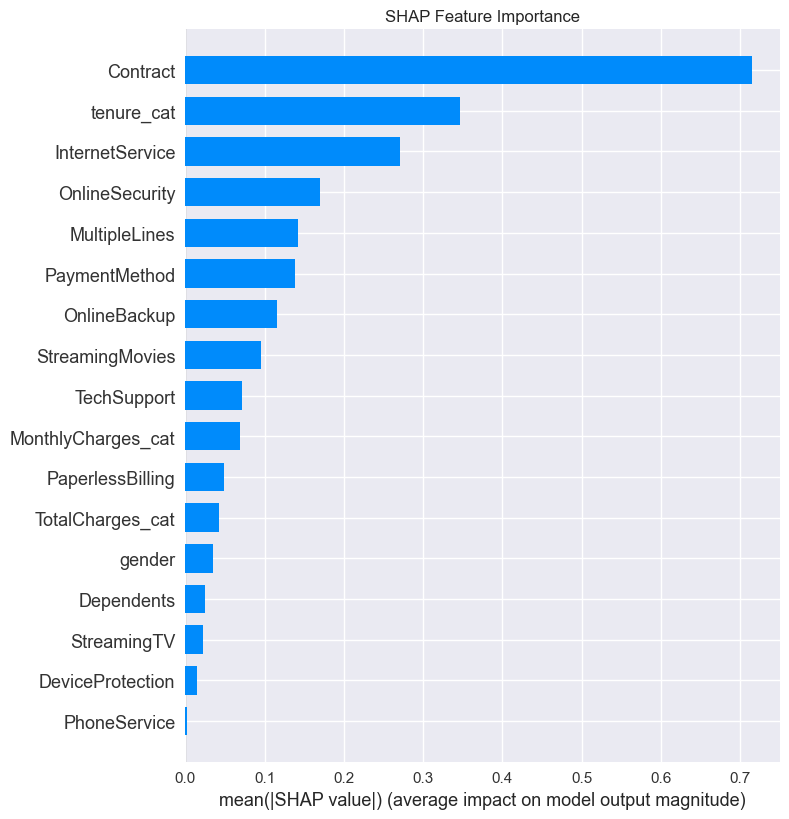

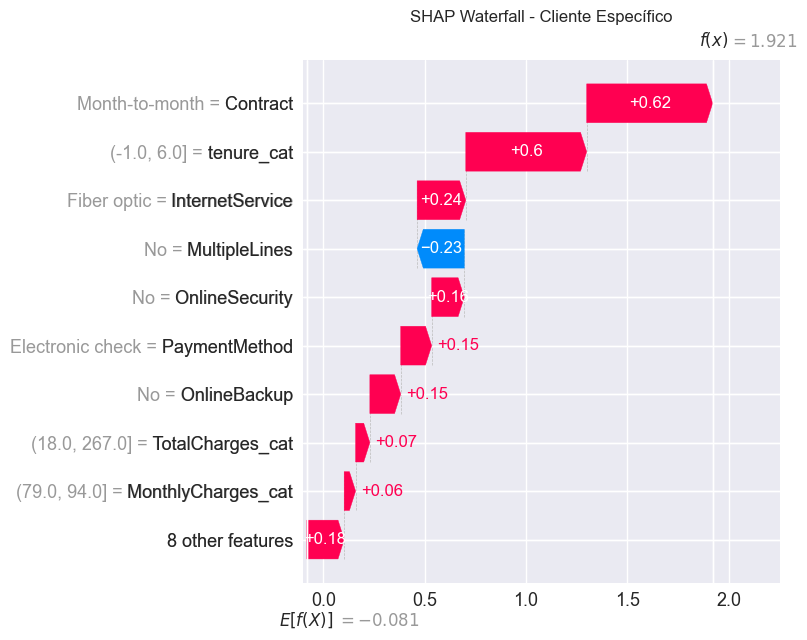

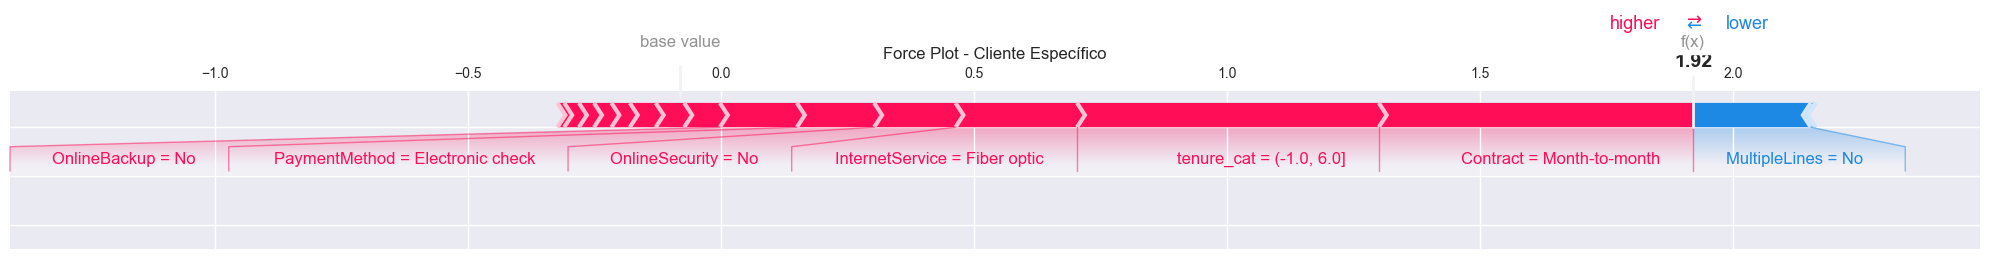

<Figure size 1000x600 with 0 Axes>

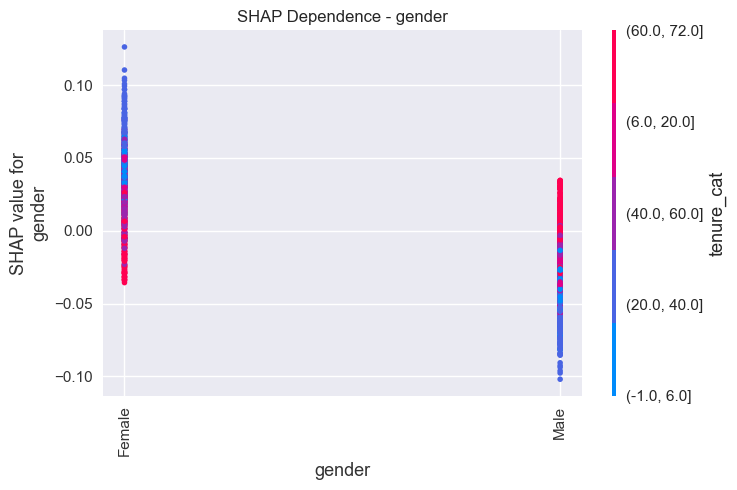

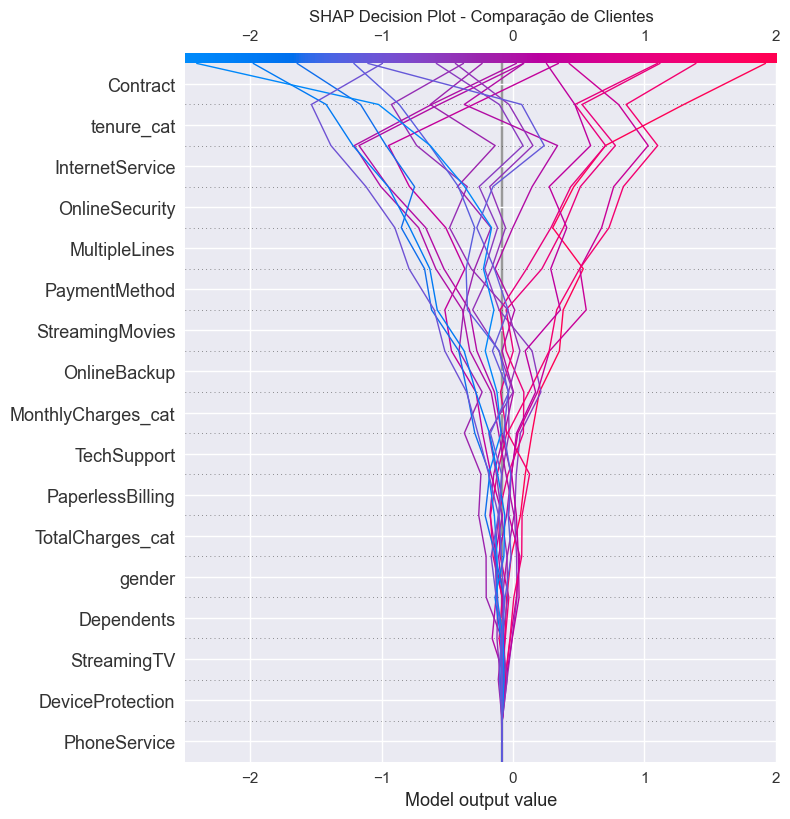

['../data/processed/shap_values.joblib']

In [14]:
# Cria explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_cal)

# Se binário, shap_values pode ser lista ou array
# Usa apenas valores da classe positiva (churn=1)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
else:
    shap_values_class1 = shap_values

# Summary Plot (importância + distribuição)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_cal, plot_type="dot", show=False)
plt.title("SHAP Summary Plot - Impacto das Features")
plt.tight_layout()
plt.savefig('../reports/figures/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Bar Plot (importância média global)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_class1, X_cal, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig('../reports/figures/shap_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Waterfall Plot (explicação individual)
# Escolhe um cliente específico (ex: índice 0)
plt.figure(figsize=(10, 8))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_class1[0],
        base_values=explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
                     else explainer.expected_value,
        data=X_cal.iloc[0],
        feature_names=X_cal.columns.tolist()
    ),
    show=False
)
plt.title("SHAP Waterfall - Cliente Específico")
plt.tight_layout()
plt.savefig('../reports/figures/shap_waterfall_example.png', dpi=150, bbox_inches='tight')
plt.show()

# Force Plot (explicação visual individual)
shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
    else explainer.expected_value,
    shap_values_class1[0],
    X_cal.iloc[0],
    matplotlib=True,
    show=False
)
plt.title("Force Plot - Cliente Específico")
plt.tight_layout()
plt.savefig('../reports/figures/shap_force_example.png', dpi=150, bbox_inches='tight')
plt.show()

# Dependence Plot (relação feature vs SHAP)
# Mostra como uma feature específica afeta as predições
top_feature = X_cal.columns[0]  # ou escolha baseado em importance
plt.figure(figsize=(10, 6))
shap.dependence_plot(
    top_feature,
    shap_values_class1,
    X_cal,
    show=False
)
plt.title(f"SHAP Dependence - {top_feature}")
plt.tight_layout()
plt.savefig(f'../reports/figures/shap_dependence_{top_feature}.png', dpi=150, bbox_inches='tight')
plt.show()

# Decision Plot (múltiplos clientes)
# Mostra caminho de decisão para vários clientes
plt.figure(figsize=(10, 8))
shap.decision_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
    else explainer.expected_value,
    shap_values_class1[:20],  # Primeiros 20 clientes
    X_cal.iloc[:20],
    show=False
)
plt.title("SHAP Decision Plot - Comparação de Clientes")
plt.tight_layout()
plt.savefig('../reports/figures/shap_decision.png', dpi=150, bbox_inches='tight')
plt.show()

# Salva SHAP values para uso no Streamlit
joblib.dump({
    'shap_values': shap_values_class1,
    'expected_value': explainer.expected_value[1] if isinstance(explainer.expected_value, list) 
                      else explainer.expected_value,
    'feature_names': X_cal.columns.tolist()
}, '../data/processed/shap_values.joblib')

In [15]:
cm.ravel()

array([915, 384,  83, 414])